In [7]:
import numpy as np
import sys
import matplotlib.pyplot as plt

from gaborfilter import gaborfilter

In [65]:
def fspecial_gauss(shape=(3,3), sigma=0.5):
    '''
    equivalent to MATLAB's fspecial('gaussian',...) function
    '''

    '''
      case 'gaussian' % Gaussian filter
         siz   = (p2-1)/2;
         std   = p3;

         [x,y] = meshgrid(-siz(2):siz(2),-siz(1):siz(1));
         arg   = -(x.*x + y.*y)/(2*std*std);

         h     = exp(arg);
         h(h<eps*max(h(:))) = 0;

         sumh = sum(h(:));
         if sumh ~= 0,
           h  = h/sumh;
         end;
    '''

    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp(-(x*x + y*y) / (2.*sigma*sigma))
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    return h / sumh if sumh != 0 else 0


def fspecial_log(p2, p3):
    '''
    equivalent to MATLAB's fspecial('log',...) function
    '''

    '''
      case 'log' % Laplacian of Gaussian
         % first calculate Gaussian
         siz   = (p2-1)/2;
         std2   = p3^2;

         [x,y] = meshgrid(-siz(2):siz(2),-siz(1):siz(1));
         arg   = -(x.*x + y.*y)/(2*std2);

         h     = exp(arg);
         h(h<eps*max(h(:))) = 0;

         sumh = sum(h(:));
         if sumh ~= 0,
           h  = h/sumh;
         end;
         % now calculate Laplacian
         h1 = h.*(x.*x + y.*y - 2*std2)/(std2^2);
         h     = h1 - sum(h1(:))/prod(p2); % make the filter sum to zero
    '''
    siz = int((p2-1)/2)
    std = p3

    x = y = np.linspace(-siz, siz, 2*siz+1)
    x, y = np.meshgrid(x, y)
    arg = -(x**2 + y**2) / (2*std**2)
    h = np.exp(arg)
    h[h < sys.float_info.epsilon * h.max()] = 0
    h = h/h.sum() if h.sum() != 0 else h
    h1 = h*(x**2 + y**2 - 2*std**2) / (std**4)
    return h1 - h1.mean()

In [89]:
def get_filters():
    '''
    define set of filters
    '''
    array = lambda x: np.array(x)

    """
    F are filters
    """

    # gradient x, gradient y filters
    # size 1 x 2
    # FILTER NUMBERS: 0 - 1
    F = [array([-1, 1]).reshape((1, 2)), array([-1, 1]).reshape((2, 1))]

    # laplacian of the gaussian filter
    # for sizes 3x3, 4x4, 5x5
    # FILTER NUMBERS: 2 - 4
    F += [fspecial_log((i-2)*2+1, (i-2)/3) for i in range(3, 5+1)]

    # gabor filters for different angles
    # for sizes 7x7, 8x8
    # angles 0, 30, 60, 90, 120, 150
    # FILTER NUMBERS: 7 - 16
    for i in range(7, 8):
        for j in range(0, 150+1, 30):
            F += gaborfilter(i, j)
    
    # dirac delta
    delta = np.zeros((3, 3))
    delta[1,1] = 1
    F += [delta]

    # pad the rest of the filters with zeros
    n_F = len(F)
    width, height = np.zeros(n_F), np.zeros(n_F)
    filters = np.zeros((n_F, np.max([f.shape[0]*f.shape[1] for f in F])))
    for i in range(n_F):
        [m, n] = F[i].shape

        F[i] = F[i] - np.mean(np.mean(F[i])) * np.ones((m, n))
        F[i] = F[i] / np.sum(np.sum(np.abs(F[i])))

        filters[i, 0:(m*n)] = np.reshape(F[i], (1, m*n))
        height[i] = n
        width[i] = m

    return F, filters, width, height

In [90]:
F, filters, width, height = get_filters()

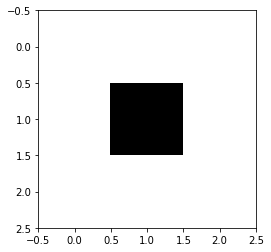

In [92]:
plt.imshow(F[-1], cmap="Greys")